In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#from sklearn.pipeline import make_pipeline, make_union
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from climada.util.constants import DEF_CRS


#from sklearn_xarray import Stacker, Select

In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

## Select and load data

In [3]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)



## Load indices

In [4]:
#get sfcT
sfcT_fn = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
sfcT = pd.read_csv(pathcirc+sfcT_fn,header=[0],index_col=[0,1]).loc[:,["sfcT"]]

#get remote indices
dind_fn1 = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
dind_fn2 = "diff_custom_indices_sp_avg_allmods_historical_ssp585.csv"
dind_fn3 = "diff_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv"


preds0 = ["pol","trop","strat"]
preds1 = ["pol","trop","strat","NAWH","Nino4-Nino3"]
preds2 = ["baro","TCWV"]
preds3 = ["NAO","EA","EAWR","SCA"]
dind_df1 = pd.read_csv(pathcirc+dind_fn1,header=[0],index_col=[0,1]).iloc[:,1:]
dind_df2 = pd.read_csv(pathcirc+dind_fn2,header=[0],index_col=[0,1])
dind_df3 = pd.read_csv(pathcirc+dind_fn3,header=[0],index_col=[0,1])

#concat 
dind_df_all = pd.concat([dind_df1,dind_df2,dind_df3],axis=1)

## Prepare model target variable

In [5]:
#select vars
modlist = modlist_allscen + modlist_ssp585
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmems_max = 3
memrange = np.arange(nmems_max)
qt = 0.98
lonout = np.arange(min_lon+2.5,max_lon-2.5,2.5)
latout = np.arange(min_lat+2.5,max_lat-2.5,2.5)
normresp = True #normalize by global warming

In [6]:
#intiate ds to save result
nameds = futname+'-'+pastname
#qtgust_ds = xr.DataArray(np.zeros([latout.size, lonout.size,nmods ,nmems_max]), 
#                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)

qtgust_ds = xr.DataArray(np.nan*np.ones([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)
#model res df
res_df = pd.DataFrame(columns=["Res"],index=modlist)

In [7]:

#loop over the models
for modid, modname in enumerate(modlist):  
    
    #read netcdf
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    ncdfw = ncdf[[pastname,futname]]
    
    #get resolutiom
    latres, lonres = get_lat_lon_res(ncdfw)
    meanres = np.sqrt(latres**2 + lonres**2)
    res_df.loc[modname,"Res"] = meanres
    res_df.loc[modname] =  meanres
    #apply gust factor
    gust_ds = gst_fact*ncdfw
    
    #get 98 quantile
    gust_qt_ds = gust_ds.quantile(qt,dim=timeres)
    #gust_qt_ds = gust_ds.mean(dim=timeres)
    #compute fut -past diff
    gust_qt_past = gust_qt_ds[pastname]
    gust_qt_fut = gust_qt_ds[futname]
    gust_qt_diff = gust_qt_fut - gust_qt_past
    
    #regrid
    gust_qt_diff = gust_qt_diff.interp(coords={"lat":latout,"lon":lonout})
    members = memname_df.loc[modname,pastname]
    nmems = nmems_max - members.isna().sum()
    range_mems = list(range(nmems))
    if normresp:
        for imem in range_mems:
            Tsmem = sfcT.loc[(modname,imem)].values
            gust_qt_diff.loc[{"member":imem}] = gust_qt_diff.loc[{"member":imem}]/Tsmem
    #write to ds
    qtgust_ds.loc[{"model":modname,"member":range_mems}] = gust_qt_diff
res_df = res_df.astype(np.float64)

In [119]:
memname_df

scen               historical                           ssp585             \
imem                        0          1          2          0          1   
CanESM5             r10i1p1f1  r10i1p2f1  r11i1p1f1  r10i1p1f1  r10i1p2f1   
CNRM-CM6-1          r10i1p1f2   r1i1p1f2   r2i1p1f2   r1i1p1f2   r2i1p1f2   
CNRM-ESM2-1          r1i1p1f2   r2i1p1f2   r3i1p1f2   r1i1p1f2   r4i1p1f2   
EC-Earth3-Veg        r1i1p1f1   r4i1p1f1   r2i1p1f1   r2i1p1f1   r3i1p1f1   
EC-Earth3-Veg-LR     r1i1p1f1   r2i1p1f1   r3i1p1f1   r1i1p1f1   r2i1p1f1   
IPSL-CM6A-LR        r10i1p1f1  r11i1p1f1  r12i1p1f1  r14i1p1f1   r4i1p1f1   
MIROC-ES2L        r1i1000p1f2  r13i1p1f2  r11i1p1f2   r1i1p1f2  r10i1p1f2   
UKESM1-0-LL          r1i1p1f2   r2i1p1f2   r3i1p1f2   r1i1p1f2   r4i1p1f2   
MRI-ESM2-0           r1i1p1f1   r2i1p1f1   r3i1p1f1   r1i1p1f1   r1i2p1f1   
FGOALS-g3            r1i1p1f1   r3i1p1f1   r5i1p1f1   r1i1p1f1   r3i1p1f1   
ACCESS-ESM1-5        r1i1p1f1   r3i1p1f1   r2i1p1f1   r1i1p1f1   r3i1p1f1   
MIROC6              r10i1p1f1   r1i1p1f1   r2i1p1f1   r1i1p1f1   r2i1p1f1   
MPI-ESM1-2-LR       r10i1p1f1   r9i1p1f1   r5i1p1f1   r1i1p1f1  r10i1p1f1   
KACE-1-0-G           r2i1p1f1   r1i1p1f1   r3i1p1f1   r1i1p1f1   r2i1p1f1   
AWI-CM-1-1-MR        r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
BCC-CSM2-MR          r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CNRM-CM6-1-HR        r1i1p1f2        NaN        NaN   r1i1p1f2        NaN   
EC-Earth3-CC         r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
HadGEM3-GC31-LL      r1i1p1f3   r2i1p1f3   r3i1p1f3   r1i1p1f3   r3i1p1f3   
GISS-E2-1-G          r1i1p1f1        NaN        NaN   r1i1p1f2        NaN   
GFDL-CM4             r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CMCC-CM2-SR5         r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CMCC-ESM2            r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
HadGEM3-GC31-MM      r1i1p1f3   r2i1p1f3   r4i1p1f3   r1i1p1f3   r3i1p1f3   
NESM3                r1i1p1f1   r2i1p1f1        NaN   r2i1p1f1   r1i1p1f1   
MPI-ESM1-2-HR       r10i1p1f1   r4i1p1f1        NaN   r1i1p1f1   r2i1p1f1   
INM-CM4-8            r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
INM-CM5-0            r5i1p1f1        NaN        NaN   r1i1p1f1        NaN   
ACCESS-CM2           r4i1p1f1   r5i1p1f1        NaN   r4i1p1f1   r5i1p1f1   

scen                        
imem                     2  
CanESM5           r1i1p1f1  
CNRM-CM6-1        r3i1p1f2  
CNRM-ESM2-1       r5i1p1f2  
EC-Earth3-Veg     r1i1p1f1  
EC-Earth3-Veg-LR  r3i1p1f1  
IPSL-CM6A-LR      r2i1p1f1  
MIROC-ES2L        r2i1p1f2  
UKESM1-0-LL       r2i1p1f2  
MRI-ESM2-0        r2i1p1f1  
FGOALS-g3         r4i1p1f1  
ACCESS-ESM1-5     r2i1p1f1  
MIROC6            r3i1p1f1  
MPI-ESM1-2-LR     r3i1p1f1  
KACE-1-0-G        r3i1p1f1  
AWI-CM-1-1-MR          NaN  
BCC-CSM2-MR            NaN  
CNRM-CM6-1-HR          NaN  
EC-Earth3-CC           NaN  
HadGEM3-GC31-LL   r2i1p1f3  
GISS-E2-1-G            NaN  
GFDL-CM4               NaN  
CMCC-CM2-SR5           NaN  
CMCC-ESM2              NaN  
HadGEM3-GC31-MM   r2i1p1f3  
NESM3                  NaN  
MPI-ESM1-2-HR          NaN  
INM-CM4-8              NaN  
INM-CM5-0              NaN  
ACCESS-CM2             NaN

## Multiple regression on q98 of wind
1) Select simulation
2) Intiate df to save results
3) Loop over models, compute q98 fut-past diff, regrid and concat into the same array
5) regression on each gridcell of the q98 map



In [8]:
##select simulation

#models
modlist = modlist_ssp585 + modlist_allscen
modlist.remove('CNRM-CM6-1-HR')

#modlist.remove('GISS-E2-1-G')
#modlist.remove('INM-CM5-0')
#modlist.remove('MRI-ESM2-0')
#modlist.remove('KACE-1-0-G')

#specify regression model
#addres = False
#addsfcT = False
#mem_avg = True

#select predictors
preds = ["pol","trop","strat","NAWH","Nino4-Nino3"] #predictors
#preds = ["baro","TCWV"] #predictors
#preds = ["NAO","EA","EAWR","SCA"]#predictors


In [9]:
#remove first member of KACE because outlier
dind_df_all_rm = dind_df_all.drop(('KACE-1-0-G',0),axis=0)
sfcT_rm = sfcT.drop(('KACE-1-0-G',0),axis=0)

In [10]:
##prepare predictors
#select df
sel_dind_memsep_df = dind_df_all_rm.copy().loc[modlist,preds]
sel_sfcT_memsep = sfcT_rm.loc[modlist]

#memmean 
sel_dind_df = sel_dind_memsep_df.groupby("model").mean()
sel_sfcT = sel_sfcT_memsep.groupby("model").mean()

#normalize by sfcT
sel_dind_df.loc[:,preds] = sel_dind_df.loc[:,preds] / sel_sfcT.values

# anomalies
an_dind_df = sel_dind_df.copy()
an_dind_df = sel_dind_df.loc[:,preds]-sel_dind_df.loc[:,preds].mean()

# standardized
std_an_dind_df = an_dind_df.copy()
std_an_dind_df.loc[:,preds] = an_dind_df/sel_dind_df.std()

In [11]:
#select and process target var
resp_ds = qtgust_ds.sel(model=modlist)#select models 
resp_ds.loc[dict(model='KACE-1-0-G',member=0)] = np.nan #replace all values of outlying members by na
resp_ds = resp_ds.mean(dim="member") #member mean

In [22]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict = {}
arr_dict_pval = {}
to_save = preds+["const","Rsq","adj_Rsq"]
for item in to_save:
    arr_dict[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds+["const"]:
    arr_dict_pval[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
        

In [23]:
##select indices and response statsmodel

yy = resp_ds
X = std_an_dind_df
try:
    X.index = X.index.droplevel(0)
except:
    pass
X = X.reindex(yy.model)
X = sm.add_constant(X) # adding a constant
    
for ii in np.arange(0,nlat,1):
    for jj in np.arange(0,nlon,1):
#         ----------------------------
        #select response variable at gridpoint
        y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
    
        #construct model
        lm = sm.OLS(y_grid_point, X) # describe model
        fit = lm.fit() # fit model
        
        #save to array
        arr_dict["Rsq"][ii,jj] = fit.rsquared
        arr_dict["adj_Rsq"][ii,jj] = fit.rsquared_adj
        for name,value in fit.params.items():
            arr_dict[name][ii,jj] = value
            
        for name,value in fit.pvalues.items():
            arr_dict_pval[name][ii,jj] = value
        
res_ds2 = xr.Dataset(arr_dict)
pval_ds = xr.Dataset(arr_dict_pval)

In [18]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict_rob = {}
arr_dict_pval_rob = {}
to_save = preds+["const","Rsq","adj_Rsq"]
for item in to_save:
    arr_dict_rob[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds+["const"]:
    arr_dict_pval_rob[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)

In [19]:
##Robust MLR

yy = resp_ds
X = std_an_dind_df
try:
    X.index = X.index.droplevel(0)
except:
    pass
X = X.reindex(yy.model)
X = sm.add_constant(X) # adding a constant
    
for ii in np.arange(0,nlat,1):
    for jj in np.arange(0,nlon,1):
#         ----------------------------
        #select response variable at gridpoint
        y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
    
        #construct model
        lm = sm.RLM(y_grid_point, X, M=sm.robust.norms.TukeyBiweight()) # describe model
        fit = lm.fit() # fit model       
        
        #Rsquared
        #yfit = fit.fittedvalues
        rsq = comp_rsq(fit,y_grid_point)
        adj_rsq = comp_adj_rsq(fit,y_grid_point,X)
        arr_dict_rob["Rsq"][ii,jj] = rsq
        arr_dict_rob["adj_Rsq"][ii,jj] = adj_rsq
    
        #save to array
        for name,value in fit.params.items():
            arr_dict_rob[name][ii,jj] = value
            
        for name,value in fit.pvalues.items():
            arr_dict_pval_rob[name][ii,jj] = value
        
res_ds_rob = xr.Dataset(arr_dict_rob)
pval_ds_rob = xr.Dataset(arr_dict_pval_rob)


## Plot indices

In [24]:
#constants
coefs = ["pol","trop","strat","NAWH","Nino4-Nino3","NAO","SCA","EA","EAWR","baro","TCWV","const"]


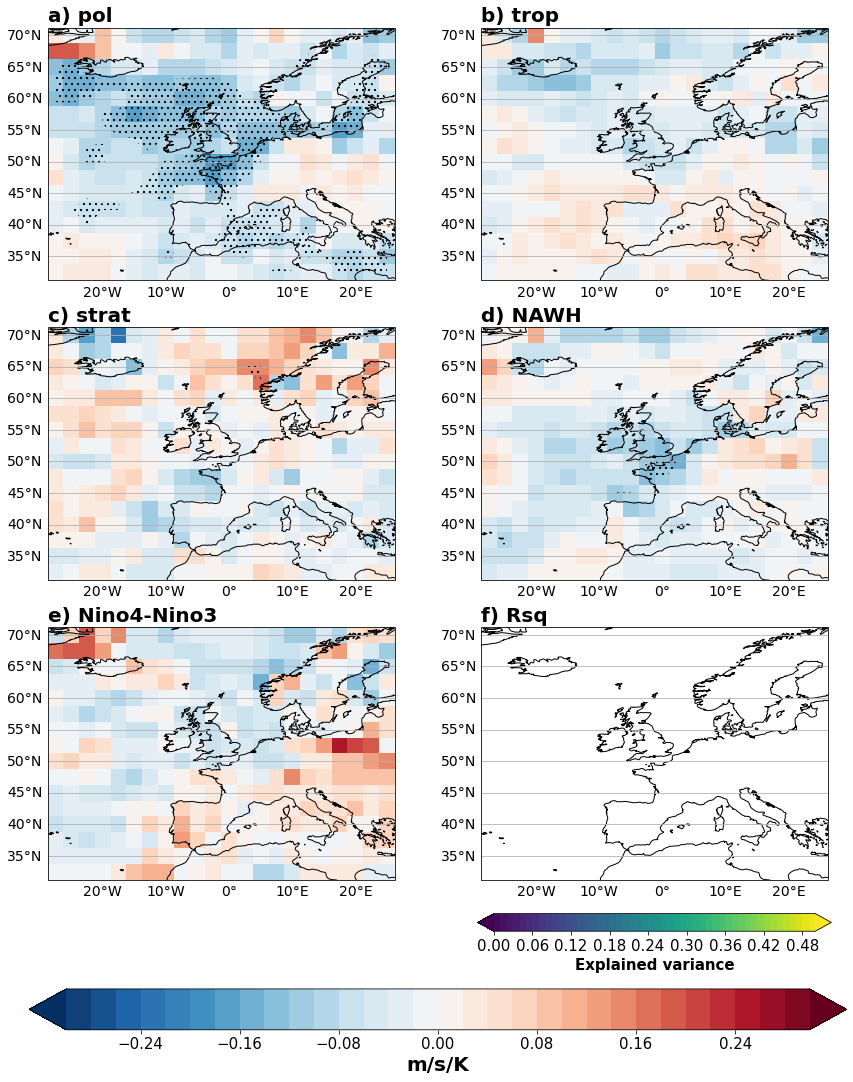

In [26]:
#select data
data = res_ds2
data_pval = pval_ds
to_plot = data.keys()
to_plot = ["pol","trop","strat","NAWH","Nino4-Nino3","Rsq"]
labels = ["a) pol","b) trop","c) strat","d) NAWH","e) Nino4-Nino3","f) Rsq"]
nfields = len(to_plot)
add_pvals = True
field_sign = True
alpha = 0.1
alphafdr = alpha


#plotting params
saving = False
nrows = 3
extent = (-80,60,10,60)
#nrows = np.max((1,round(nfields/2)+nfields%2))
ncols = 2
#namings
savelocation="results/figures/CircScen/coefs/"
savefileName = make_fn(['mlr','SWM','OLS','reg','q98','coefs']+to_plot,filetype='.png')

#color levels
colorbarMin=-0.3
colorbarMax=0.3
colorspace=0.02
clevel_coef = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=0
colorbarMax=0.5
colorspace=0.01
clevel_R = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
colorspace=0.05
clevel_Rlab = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

#hatches pvals
hatches =  ['..','']

#initiate plot
fig = plt.figure(constrained_layout=True,figsize=(6*ncols,5*nrows))
axs = fig.subplots(nrows=nrows, ncols=ncols,sharex=False,sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}).flatten()

hcoefs = [] #handle lists
helse = []
for i,varname in enumerate(to_plot):
    axi = axs[i]
    da = data[varname]
    label = labels[i]
    
    if varname in coefs:
        clevs = clevel_coef
        color = 'RdBu_r'
        if normresp:
            labelc = 'm/s/K'
        else:
            labelc = 'm/s'
    else:
        clevs = clevel_R
        color = 'viridis'
        labelr = 'Explained variance'
    
    #clevs = dict_cbar[varname][0]
    #color = dict_cbar[varname][1]

    h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False)
    
    if varname in coefs:
        hcoefs.append(h)
    else:
        helse.append(h)
        
    
    # coastlines
    axi.coastlines()
    #axi.set_extent(extent)
    axi.set_visible(True)
    axi.set_title(label,fontsize=20,fontweight='bold',loc='left')
    gl = axi.gridlines(crs=ccrs.PlateCarree(), draw_labels={"bottom": "x", "left": "y"})
    gl.xlines = False
    gl.xlabel_style = {'size': 14, 'color': 'black'}#,'weight': 'bold'
    gl.ylabel_style = {'size': 14, 'color': 'black'}#,'weight': 'bold'
    #pvals
    if add_pvals:
        if varname in preds+["const"]:
            da_pv = data_pval[varname]
            if field_sign:
                ps = da_pv.to_numpy().flatten()
                ps.sort()
                Ntests = len(ps)
                test = ps[ps<=np.arange(1,Ntests+1)*alphafdr/Ntests]
                if np.any(test):
                    pfdr = np.max(test)
                else: 
                    print("/!\ No field significance for: "+varname)
                    continue
                p_levels = [0.0, pfdr]
            else:
                p_levels = [0.0, alpha]
            
            da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False)
            axi.set_title(label,fontsize=20,fontweight='bold',loc='left')
        
#add colorbar
cbar_coefs = fig.colorbar(hcoefs[0], ax=axs[:-1],orientation='horizontal',extendrect=False,fraction=0.05, pad=0.1)
cbar_coefs.ax.tick_params(labelsize=15) 
if len(helse) != 0:
    cbar_rsq = fig.colorbar(helse[0],ax=axs[-1],orientation='horizontal',extendrect=False,fraction=0.07, pad=0.05)
    cbar_rsq.ax.tick_params(labelsize=15) 

#label = labels[i]
cbar_coefs.set_label(label=labelc,fontsize=20,fontweight='bold')
cbar_rsq.set_label(label=labelr,fontsize=15,fontweight='bold')


#axi.set_title(varname,fontsize=20,fontweight='bold')
if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

## Temporal correlation with U850 wind

In [778]:
#select vars
basenamemetU850 = 'UA_rg_25_mon_NH_winE'
pathinvarU850 = pathcmip6+'ua/'
modlist = modlist_ua
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmonths = 354
monthid = np.arange(nmonths)
qt = 0.98
lonout = np.arange(min_lon,max_lon,2.5)
lonout = (lonout + 180) % 360 - 180
lonout.sort()
latout = np.arange(min_lat,max_lat,2.5)
normresp = False #normalize by global warming

In [779]:
#intiate ds to save result
namep = pastname
namef = futname
named = futname+'-'+pastname
#qtgust_ds = xr.DataArray(np.zeros([latout.size, lonout.size,nmods ,nmems_max]), 
#                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)


past_corr_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ]), 
                                          coords=[latout, lonout, modlist], dims=['lat','lon','model'], name=namep)  
fut_corr_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ]), 
                                          coords=[latout, lonout, modlist], dims=['lat','lon','model'], name=namef)  
diff_corr_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ]), 
                                          coords=[latout, lonout, modlist], dims=['lat','lon','model'], name=named)  


In [780]:
#loop over the models
for modid, modname in enumerate(modlist):  
    
    #read netcdf
    #Uwind
    fnU850 = make_fn([modname],basenamemetU850,filetype=".nc")
    ncdfU850 = xr.open_dataset(pathinvarU850+fnU850)
    
    #sfcWindmax
    fnSWM = make_fn([modname],basenamemet,filetype=".nc")
    ncdfSWM = xr.open_dataset(pathinvar+fnSWM)
    
    #get member mean 
    ncdfSWM = ncdfSWM.mean(dim="member")
    ncdfU850 = ncdfU850.mean(dim="member")
    
    #regrid
    ncdfSWM = ncdfSWM.interp(coords={"lat":latout,"lon":lonout})
    ncdfU850 = ncdfU850.interp(coords={"lat":latout,"lon":lonout})
    
    #swap coords
    ncdfU850p = ncdfU850[[pastname,"timep"]]
    ncdfU850f = ncdfU850[[futname,"timef"]]    
    ncdfSWMp = ncdfSWM[[pastname,"timep"]]
    ncdfSWMf = ncdfSWM[[futname,"timef"]]
    ncdfSWMp = ncdfSWMp.assign_coords(time=ncdfSWMp["timep"]).swap_dims({"day":"time"})
    ncdfSWMf = ncdfSWMf.assign_coords(time=ncdfSWMf["timef"]).swap_dims({"day":"time"})
    ncdfU850p = ncdfU850p.assign_coords(time=ncdfU850p["timep"]).swap_dims({"day":"time"})
    ncdfU850f = ncdfU850f.assign_coords(time=ncdfU850f["timef"]).swap_dims({"day":"time"})
    
    #resample daily to monthly
    ncdfSWMp = ncdfSWMp.resample(time="1M").mean().dropna(dim="time",how="all")
    ncdfSWMf = ncdfSWMf.resample(time="1M").mean().dropna(dim="time",how="all")
    
    #reswap coords to have same as U850
    ncdfSWMp = ncdfSWMp.assign_coords(time=ncdfU850p["timep"])
    ncdfSWMf = ncdfSWMf.assign_coords(time=ncdfU850f["timef"])
    
    #get correl + write to da
    past_corr_da.loc[{"model":modname}] = xr.corr(ncdfSWMp[pastname],ncdfU850p[pastname],dim="time")
    fut_corr_da.loc[{"model":modname}] = xr.corr(ncdfSWMf[futname],ncdfU850f[futname],dim="time")
    #diff_corr_da.loc[{"model":modname}] = gust_mean_diff


corr_ds = xr.merge([past_corr_da,fut_corr_da])


In [783]:
mean_ds = corr_ds.mean(dim="model")
mean_ds.where(mean_ds>=0).mean()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    historical  float64 0.4345
    ssp585      float64 0.4264

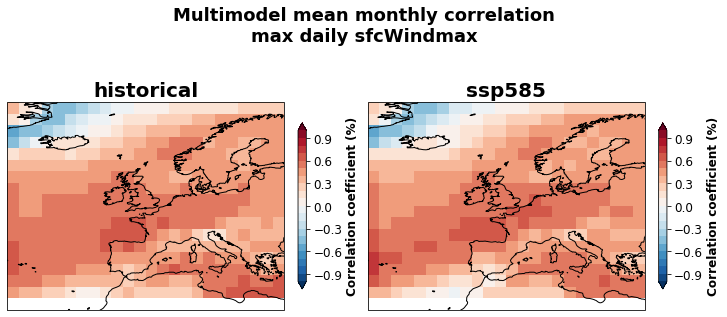

In [784]:
## check correlation
data = corr_ds.mean(dim="model")

fig = plt.figure(constrained_layout=True,figsize=(10,5))
axs = fig.subplots(nrows=1, ncols=2,subplot_kw={'projection': ccrs.PlateCarree()}).flatten()
fig.suptitle('Multimodel mean monthly correlation\nmax daily sfcWindmax',fontsize=18,fontweight='bold')
#color levels
colorbarMin=-1
colorbarMax=1
colorspace=0.1
clevel_corr = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
#color = 'Reds'
color = 'RdBu_r'

for i, name in enumerate(corr_ds):
    da = data[name]
    ax = axs[i]
    h = da.plot(ax=ax,extend='both',levels=clevel_corr,cmap=color,add_colorbar=False)
    
    #plot the colorbar:
    cbar = fig.colorbar(h, ax=ax,orientation='vertical', fraction=0.03, pad=0.05)
    cbar.ax.tick_params(labelsize=12) 
    colorLabel='Correlation coefficient (%)' 
    colorbarMin=-3
    cbar.set_label(label=colorLabel,fontsize=12,fontweight='bold')
    
    ax.set_title(name,fontsize=20,fontweight='bold')
    # coastlines
    ax.coastlines()
    ax.set_visible(True)

## Model correlation with U850 wind

In [865]:
#select vars
basenamemetU850 = 'UA_rg_25_mon_NH_winE'
pathinvarU850 = pathcmip6+'ua/'
modlist = modlist_ua
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmonths = 354
monthid = np.arange(nmonths)
nmems_max = 1
memrange = range(nmems_max)
qt = 0.98
lonout = np.arange(min_lon,max_lon,2.5)
lonout = (lonout + 180) % 360 - 180
lonout.sort()
latout = np.arange(min_lat,max_lat,2.5)
normresp = False #normalize by global warming


In [866]:
#intiate ds to save result
namep = pastname
namef = futname
named = futname+'-'+pastname
#qtgust_ds = xr.DataArray(np.zeros([latout.size, lonout.size,nmods ,nmems_max]), 
#                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)


past_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=namep)  
fut_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=namef)  
diff_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=named)  


In [867]:
#surface temperature for normalizing
Ts_df = std_an_dind_memsep_df.loc[modlist,["sfcT"]]

#loop over the models
for modid, modname in enumerate(modlist):  
    
    #read netcdf
    fn = make_fn([modname],basenamemetU850,filetype=".nc")
    ncdf = xr.open_dataset(pathinvarU850+fn)
    ncdfw = ncdf[[pastname,futname]]
    
    #apply gust factor
    gust_ds = gst_fact*ncdfw
    
    #get 98 quantile
    gust_mean_ds = ncdfw.mean(dim=timeres)
    #memmean
    #gust_mean_ds = gust_mean_ds.mean(dim="member")
    
    #regrid
    gust_mean_ds = gust_mean_ds.interp(coords={"lat":latout,"lon":lonout})
    
    #compute fut -past diff
    gust_mean_past = gust_mean_ds[pastname]
    gust_mean_fut = gust_mean_ds[futname]
    gust_mean_diff = gust_mean_fut - gust_mean_past
    
    members = memname_df.loc[modname,pastname]
    nmems = max(nmems_max - members.isna().sum(),1)
    range_mems = list(range(nmems))
    if normresp:
        for imem in range_mems:
            Tsmem = Ts_df.loc[(modname,imem)].values
            gust_mean_diff.loc[{"member":imem}] = gust_mean_diff.loc[{"member":imem}]/Tsmem
    #write to ds
    past_da.loc[{"model":modname,"member":range_mems}] = gust_mean_past
    fut_da.loc[{"model":modname,"member":range_mems}] = gust_mean_fut
    diff_da.loc[{"model":modname,"member":range_mems}] = gust_mean_diff

U850_ds = xr.merge([past_da,fut_da,diff_da])

In [883]:
#intermodel correlation
qtgust_ds_ss = qtgust_ds.isel(member=0)
U850_ds_ss = U850_ds["ssp585-historical"].mean(dim="member")
model_corr_ds = xr.corr(qtgust_ds_ss,U850_ds_ss,dim="model")

Spatial average correlation: 0.235


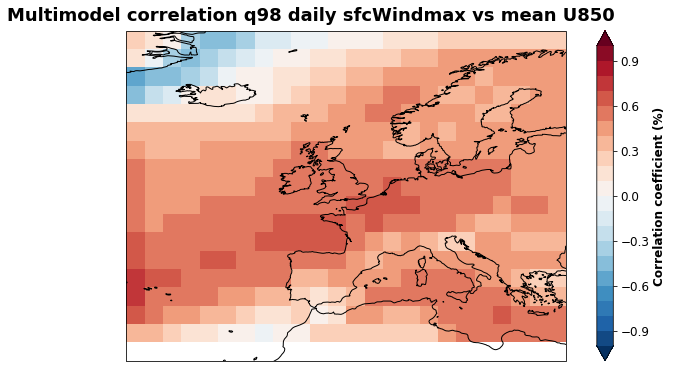

In [884]:
#plots

data = model_corr_ds
fig = plt.figure(constrained_layout=True,figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=1,subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Multimodel correlation q98 daily sfcWindmax vs mean U850',fontsize=18,fontweight='bold')
#color levels
colorbarMin=-1
colorbarMax=1
colorspace=0.1
clevel_corr = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
#color = 'Reds'
color = 'RdBu_r'
    
h = da.plot(ax=ax,extend='both',levels=clevel_corr,cmap=color,add_colorbar=False)

#plot the colorbar:
cbar = fig.colorbar(h, ax=ax,orientation='vertical', fraction=0.03, pad=0.05)
cbar.ax.tick_params(labelsize=12) 
colorLabel='Correlation coefficient (%)' 
colorbarMin=-3
cbar.set_label(label=colorLabel,fontsize=12,fontweight='bold')

#ax.set_title(name,fontsize=20,fontweight='bold')
# coastlines
ax.coastlines()
ax.set_visible(True)
print("Spatial average correlation: "+format((data.mean().values),'.3f'))

In [878]:
format((data.mean().values),'.3f')

'0.313'

In [845]:
name

<xarray.DataArray 'ssp585-historical' (lon: 22)>
array([ 0.484641  ,  0.47546102,  0.39092741,  0.37450701,  0.45161157,
        0.41132732,  0.20264974,  0.28487566,  0.04917573, -0.00582752,
        0.09160387,  0.24962096,  0.18414232,  0.18571041,  0.07904271,
        0.21182544,  0.25275341,  0.24098779,  0.18319004,  0.29987446,
        0.28445671,  0.27498745])
Coordinates:
    lat      float64 32.5
  * lon      (lon) float64 -27.5 -25.0 -22.5 -20.0 -17.5 ... 17.5 20.0 22.5 25.0
    member   int64 0

In [841]:
ax

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

In [837]:
data

<xarray.DataArray 'ssp585-historical' (lat: 16, lon: 22)>
array([[ 0.484641  ,  0.47546102,  0.39092741,  0.37450701,  0.45161157,
         0.41132732,  0.20264974,  0.28487566,  0.04917573, -0.00582752,
         0.09160387,  0.24962096,  0.18414232,  0.18571041,  0.07904271,
         0.21182544,  0.25275341,  0.24098779,  0.18319004,  0.29987446,
         0.28445671,  0.27498745],
       [ 0.51093932,  0.41888472,  0.2655817 ,  0.40499035,  0.44028346,
         0.48169281,  0.44448428,  0.409747  ,  0.30631903, -0.22616063,
        -0.05731886,  0.24160555,  0.35910662,  0.24465198,  0.20721942,
         0.00536595, -0.24347036, -0.12735969, -0.12512082,  0.06316009,
         0.14818301, -0.00595537],
       [ 0.4261059 ,  0.39039323,  0.36905769,  0.48703327,  0.42444605,
         0.42517569,  0.56848548,  0.44211209,  0.20234132, -0.14240045,
         0.10801689,  0.16725327,  0.14680213, -0.02964396, -0.13578355,
        -0.20211022, -0.23050047, -0.13782161,  0.01702472,  0.18953567,
        -0.08600795, -0.48345594],
       [ 0.35589145,  0.38899114,  0.48682478,  0.47345787,  0.51486123,
         0.50394259,  0.55493027,  0.56813398,  0.35543314,  0.22892889,
         0.19391166,  0.19862037, -0.00625513, -0.03968994,  0.08643894,
        -0.08405598,  0.15200076,  0.29851191,  0.34738949,  0.49588114,
        -0.03091017, -0.21740647],
...
       [ 0.0248949 , -0.12923308, -0.16842584,  0.00322106,  0.0804834 ,
         0.13630834,  0.17488569,  0.16924472,  0.18409695,  0.20302191,
         0.24395115,  0.28920144,  0.32459132,  0.46678687,  0.12647466,
        -0.02184571,  0.3362477 ,  0.45398004,  0.67848175,  0.70447433,
         0.22712238,  0.23202191],
       [-0.01060291,  0.03910816, -0.1766594 , -0.17182964, -0.13348579,
        -0.24818331, -0.05297472, -0.09833641, -0.15155411, -0.05765598,
         0.12986558,  0.2111082 ,  0.29420424,  0.41157481,  0.55274778,
         0.58719244,  0.22882435,  0.11045485,  0.13662264,  0.28036791,
         0.46796125,  0.54105936],
       [ 0.15890064,  0.14155129,  0.12919875,  0.11157056,  0.17996044,
         0.16941637,  0.13864096,  0.13257652,  0.07364604,  0.10088448,
         0.12279076,  0.15683515,  0.30494363,  0.39134402,  0.41617663,
         0.4445263 ,  0.44246381,  0.05385712, -0.11521203,  0.10600159,
         0.22519909,  0.22517954],
       [ 0.0532803 ,  0.0968713 ,  0.11392699, -0.03683477, -0.07185484,
         0.04935972,  0.08808187, -0.00315664, -0.05847144, -0.04266852,
        -0.0022477 ,  0.01884287,  0.02566892,  0.08249701,  0.15536937,
         0.16288121,  0.17906685,  0.25220947,  0.20546664,  0.13216478,
         0.10221168,  0.14918555]])
Coordinates:
  * lat      (lat) float64 32.5 35.0 37.5 40.0 42.5 ... 60.0 62.5 65.0 67.5 70.0
  * lon      (lon) float64 -27.5 -25.0 -22.5 -20.0 -17.5 ... 17.5 20.0 22.5 25.0
    member   int64 0